# Theano implementation of MNIST Handwritten Digits Classifier

In [1]:
# import packages
import theano as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import sys, os
%matplotlib inline

In [2]:
# Load the Training and Test data
df = pd.read_csv("..\..\DataSet\mnist_train.csv", encoding="UTF-8")

In [3]:
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# input and output Split
X = df.iloc[:,1:].to_numpy() / 255
Y = df.iloc[:,0].to_numpy()

In [5]:
print(X.shape, Y.shape)

(60000, 784) (60000,)


In [6]:
# Train and Test split
Xtrain, Xtest, Ytrain, Ytest = X[:-1000], X[-1000:],Y[:-1000],Y[-1000:]

In [7]:
# Shuffle the data prior training
Xtrain, Ytrain = shuffle(Xtrain, Ytrain, random_state=1)

In [8]:
# show image func
def showImage(x, y):
    plt.title("Digit: " + str(y))
    plt.imshow(x.reshape(28,28))

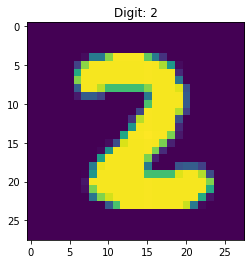

In [9]:
# Sample photo
photo = 0
showImage(Xtrain[photo], Ytrain[photo])

In [10]:
def oneHotEncode(y):
    # Target index matrix from Ytrain
    T = np.zeros((y.shape[0], np.unique(y).shape[0]))

    for i,val in enumerate(y):
        T[i,val] = 1

    return T

In [16]:
def accuracy(y, yhat):
    return np.mean(y==yhat)

In [42]:
N = Xtrain.shape[0] # Num samples in training data
D = Xtrain.shape[1] # Num input features
batch_size=10000 # Batch Size
n_batches = N // batch_size # Num batches

M = 100 # hidden layer nodes
K = 10 # Num Output features
lr = 0.01 # Learning Rate

momentum = 0.99 # Momentum const
decay = 0.999 # Decay const
epsilon = 1e-8 # Tiny positive value
iterations = 100 # Num iterations

Ctrain = [] # Train Cost
np.random.seed(1) # Random seed for Weights

T = oneHotEncode(Ytrain) # Apply One Hot Encoding for Training Outputs

Xm = th.tensor.matrix('Xtrain') # Input Tensor
Ym = th.tensor.matrix('T') # Output Tensor

W1_init = np.random.randn(D,M) # Weight initialization for W between input and hidden
b1_init = np.random.randn(M) # Weight initialization for Bias at hidden layer
W2_init = np.random.randn(M,K) # Weight initialization for W between hidden and output
b2_init = np.random.randn(K) # Weight initialization for Bias at output layer

W1 = th.shared(W1_init, "w1") # Shared Variable W1
b1 = th.shared(b1_init, "b1") # Shared Variable b1
W2 = th.shared(W2_init, "w2") # Shared Variable W2
b2 = th.shared(b2_init, "b2") # Shared Variable b2

Vw1 = th.shared(np.zeros((D,M)), "Vw1") # Shared Variable Velocity Vw1 
Vb1 = th.shared(np.zeros((M)), "Vb1") # Shared Variable Velocity Vb1
Vw2 = th.shared(np.zeros((M,K)), "Vw2") # Shared Variable Velocity Vw2
Vb2 = th.shared(np.zeros((K)), "Vb2") # Shared Variable Velocity Vb2

cache_w1 = th.shared(np.zeros((D,M)), "cache_w1") # Shared Variable Cache_w1
cache_b1 = th.shared(np.zeros((M)), "cache_b1") # Shared Variable Cache_b1
cache_w2 = th.shared(np.zeros((M,K)), "cache_w2") # Shared Variable Cache_w2
cache_b2 = th.shared(np.zeros((K)), "cache_b2") # Shared Variable Cache_b2

Z1 = th.tensor.nnet.relu(th.tensor.dot(Xm,W1)+b1) # Dot prodcut with input to hidden and apply relu
Z2 = th.tensor.nnet.softmax(th.tensor.dot(Z1,W2)+b2) # Dot product with hidden to output and apply softmax

cost = -(Ym*th.tensor.log(Z2)).mean() # Cost Function
predict = th.tensor.argmax(Z2, axis=1) # Predict function
t = th.shared(1, "t") # Timestep for Adam

# momentum term
Vw1_update = Vw1 * momentum + (1 - momentum) * th.tensor.grad(cost,W1)
Vb1_update = Vb1 * momentum + (1 - momentum) * th.tensor.grad(cost,b1)
Vw2_update = Vw2 * momentum + (1 - momentum) * th.tensor.grad(cost,W2)
Vb2_update = Vb2 * momentum + (1 - momentum) * th.tensor.grad(cost,b2)

# Bias correction
Vw1_update_correct = Vw1_update / (1 - momentum**t)
Vb1_update_correct = Vb1_update / (1 - momentum**t)
Vw2_update_correct = Vw2_update / (1 - momentum**t)
Vb2_update_correct = Vb2_update / (1 - momentum**t)

# RMSProp term
cache_w1_update = cache_w1 * decay + (1 - decay) * th.tensor.grad(cost,W1)**2
cache_b1_update = cache_b1 * decay + (1 - decay) * th.tensor.grad(cost,b1)**2
cache_w2_update = cache_w2 * decay + (1 - decay) * th.tensor.grad(cost,W2)**2
cache_b2_update = cache_b2 * decay + (1 - decay) * th.tensor.grad(cost,b2)**2

# Bias correction
cache_w1_update_correct = cache_w1_update / (1 - decay**t)
cache_b1_update_correct = cache_b1_update / (1 - decay**t)
cache_w2_update_correct = cache_w2_update / (1 - decay**t)
cache_b2_update_correct = cache_b2_update / (1 - decay**t)

# Weights Update with ADAM
W1_update = W1 - lr * th.tensor.grad(cost,W1) / (th.tensor.sqrt(cache_w1_update_correct) + epsilon)
b1_update = b1 - lr * th.tensor.grad(cost,b1) / (th.tensor.sqrt(cache_b1_update_correct) + epsilon)
W2_update = W2 - lr * th.tensor.grad(cost,W2) / (th.tensor.sqrt(cache_w2_update_correct) + epsilon)
b2_update = b2 - lr * th.tensor.grad(cost,b2) / (th.tensor.sqrt(cache_b2_update_correct) + epsilon)

# Train func
train = th.function(inputs=(Xm,Ym), outputs=cost, updates=[(W1, W1_update),
                                                           (b1, b1_update),
                                                           (W2, W2_update),
                                                           (b2, b2_update),
                                                           (Vw1, Vw1_update),
                                                           (Vb1, Vb1_update),
                                                           (Vw2, Vw2_update),
                                                           (Vb2, Vb2_update),
                                                           (cache_w1, cache_w1_update),
                                                           (cache_b1, cache_b1_update),
                                                           (cache_w2, cache_w2_update),
                                                           (cache_b2, cache_b2_update),
                                                           (t,t+1)])

# Get prediction func
get_predict = th.function(inputs=[Xm,Ym], outputs=[cost,predict])

# Iterations with Mini Batches
for i in range(iterations+1):
    for j in range(n_batches):
        c = train(Xtrain[j*batch_size:(j+1)*batch_size],T[j*batch_size:(j+1)*batch_size]) # Mini Batch training
        _, yhat = get_predict(Xtrain, T) # Prediction for whole Training Data
        
        Ctrain.append(c)
        print("Iteration: "+ str(i)+ " | Batch: " + str(j+1) + " | Cost: "+ str(c) + " | Accuracy: " + str(accuracy(Ytrain,yhat)*100) +"%")

Iteration: 0 | Batch: 1 | Cost: 6.071600744357522 | Accuracy: 15.166101694915254%
Iteration: 0 | Batch: 2 | Cost: 4.912615054798073 | Accuracy: 19.80508474576271%
Iteration: 0 | Batch: 3 | Cost: 3.9862110780144144 | Accuracy: 25.73050847457627%
Iteration: 0 | Batch: 4 | Cost: 3.1982770619061354 | Accuracy: 31.105084745762714%
Iteration: 0 | Batch: 5 | Cost: 2.7687380958814622 | Accuracy: 37.47118644067797%
Iteration: 1 | Batch: 1 | Cost: 2.372545684313313 | Accuracy: 40.44915254237288%
Iteration: 1 | Batch: 2 | Cost: 2.1111882626516576 | Accuracy: 45.545762711864406%
Iteration: 1 | Batch: 3 | Cost: 1.8886591991329496 | Accuracy: 48.11864406779661%
Iteration: 1 | Batch: 4 | Cost: 1.629250029092837 | Accuracy: 52.80508474576271%
Iteration: 1 | Batch: 5 | Cost: 1.5519216075812103 | Accuracy: 55.052542372881355%
Iteration: 2 | Batch: 1 | Cost: 1.404242167558447 | Accuracy: 58.63898305084746%
Iteration: 2 | Batch: 2 | Cost: 1.2734558524693305 | Accuracy: 59.747457627118635%
Iteration: 2 | B

Iteration: 19 | Batch: 5 | Cost: 0.17377032426522493 | Accuracy: 89.49322033898305%
Iteration: 20 | Batch: 1 | Cost: 0.1887573178531048 | Accuracy: 89.33898305084746%
Iteration: 20 | Batch: 2 | Cost: 0.17709321828032207 | Accuracy: 89.51525423728813%
Iteration: 20 | Batch: 3 | Cost: 0.18427640730113679 | Accuracy: 89.9186440677966%
Iteration: 20 | Batch: 4 | Cost: 0.16809190402432142 | Accuracy: 90.0406779661017%
Iteration: 20 | Batch: 5 | Cost: 0.16022359954782606 | Accuracy: 90.13220338983051%
Iteration: 21 | Batch: 1 | Cost: 0.1696672683833384 | Accuracy: 90.16440677966102%
Iteration: 21 | Batch: 2 | Cost: 0.1592909229063062 | Accuracy: 90.12372881355932%
Iteration: 21 | Batch: 3 | Cost: 0.16942917080922212 | Accuracy: 90.19661016949152%
Iteration: 21 | Batch: 4 | Cost: 0.15937709364559893 | Accuracy: 90.3864406779661%
Iteration: 21 | Batch: 5 | Cost: 0.1483936944237785 | Accuracy: 90.5271186440678%
Iteration: 22 | Batch: 1 | Cost: 0.15928115631663603 | Accuracy: 90.59491525423728%


Iteration: 39 | Batch: 2 | Cost: 0.09054336207923412 | Accuracy: 92.54406779661018%
Iteration: 39 | Batch: 3 | Cost: 0.09928424954868266 | Accuracy: 92.83389830508474%
Iteration: 39 | Batch: 4 | Cost: 0.09240450530027751 | Accuracy: 92.9728813559322%
Iteration: 39 | Batch: 5 | Cost: 0.08314257483623656 | Accuracy: 93.10508474576271%
Iteration: 40 | Batch: 1 | Cost: 0.09106826296762778 | Accuracy: 93.05254237288135%
Iteration: 40 | Batch: 2 | Cost: 0.07896270891143492 | Accuracy: 93.4%
Iteration: 40 | Batch: 3 | Cost: 0.08660102107123238 | Accuracy: 93.42542372881356%
Iteration: 40 | Batch: 4 | Cost: 0.08147684895578011 | Accuracy: 93.63559322033899%
Iteration: 40 | Batch: 5 | Cost: 0.07256145270218167 | Accuracy: 93.59152542372881%
Iteration: 41 | Batch: 1 | Cost: 0.08100070203530108 | Accuracy: 93.79152542372881%
Iteration: 41 | Batch: 2 | Cost: 0.06994585901999427 | Accuracy: 93.66779661016949%
Iteration: 41 | Batch: 3 | Cost: 0.08139865681876202 | Accuracy: 93.63220338983051%
Iterat

Iteration: 58 | Batch: 5 | Cost: 0.04429191036884826 | Accuracy: 94.92033898305084%
Iteration: 59 | Batch: 1 | Cost: 0.053668060647965365 | Accuracy: 94.26271186440678%
Iteration: 59 | Batch: 2 | Cost: 0.04829837225968681 | Accuracy: 94.05762711864408%
Iteration: 59 | Batch: 3 | Cost: 0.059963223451759674 | Accuracy: 94.27796610169491%
Iteration: 59 | Batch: 4 | Cost: 0.05731552590534137 | Accuracy: 94.16440677966101%
Iteration: 59 | Batch: 5 | Cost: 0.05177910858899922 | Accuracy: 94.06271186440678%
Iteration: 60 | Batch: 1 | Cost: 0.05799464988098446 | Accuracy: 94.29322033898305%
Iteration: 60 | Batch: 2 | Cost: 0.04760406176632219 | Accuracy: 94.5728813559322%
Iteration: 60 | Batch: 3 | Cost: 0.05641656589560864 | Accuracy: 94.68305084745762%
Iteration: 60 | Batch: 4 | Cost: 0.052693905906130614 | Accuracy: 94.95423728813559%
Iteration: 60 | Batch: 5 | Cost: 0.043155436473792816 | Accuracy: 95.07966101694916%
Iteration: 61 | Batch: 1 | Cost: 0.050840817412478846 | Accuracy: 94.7372

Iteration: 78 | Batch: 2 | Cost: 0.0256107166097078 | Accuracy: 95.94745762711865%
Iteration: 78 | Batch: 3 | Cost: 0.03325807047734299 | Accuracy: 95.96101694915255%
Iteration: 78 | Batch: 4 | Cost: 0.031873237954347496 | Accuracy: 96.10169491525423%
Iteration: 78 | Batch: 5 | Cost: 0.02703164420180198 | Accuracy: 96.17966101694915%
Iteration: 79 | Batch: 1 | Cost: 0.032446994667226496 | Accuracy: 95.53898305084746%
Iteration: 79 | Batch: 2 | Cost: 0.027860016535892727 | Accuracy: 95.48305084745763%
Iteration: 79 | Batch: 3 | Cost: 0.036053755156862245 | Accuracy: 95.66610169491526%
Iteration: 79 | Batch: 4 | Cost: 0.03457417287266544 | Accuracy: 95.81864406779661%
Iteration: 79 | Batch: 5 | Cost: 0.028974765836970638 | Accuracy: 95.7322033898305%
Iteration: 80 | Batch: 1 | Cost: 0.034547031192537825 | Accuracy: 95.45254237288135%
Iteration: 80 | Batch: 2 | Cost: 0.029044609464815775 | Accuracy: 95.48474576271187%
Iteration: 80 | Batch: 3 | Cost: 0.03668858979745034 | Accuracy: 95.696

Iteration: 98 | Batch: 1 | Cost: 0.01997395054732167 | Accuracy: 97.03220338983051%
Iteration: 98 | Batch: 2 | Cost: 0.015130840563336755 | Accuracy: 97.06101694915255%
Iteration: 98 | Batch: 3 | Cost: 0.02038482671784301 | Accuracy: 97.14237288135593%
Iteration: 98 | Batch: 4 | Cost: 0.019825686796839558 | Accuracy: 97.15762711864406%
Iteration: 98 | Batch: 5 | Cost: 0.01682512625662371 | Accuracy: 97.18983050847457%
Iteration: 99 | Batch: 1 | Cost: 0.019329395710288 | Accuracy: 97.08813559322034%
Iteration: 99 | Batch: 2 | Cost: 0.014484429773775523 | Accuracy: 97.1593220338983%
Iteration: 99 | Batch: 3 | Cost: 0.019843084289871676 | Accuracy: 97.09830508474576%
Iteration: 99 | Batch: 4 | Cost: 0.019596707149857923 | Accuracy: 97.06271186440678%
Iteration: 99 | Batch: 5 | Cost: 0.016793314138447077 | Accuracy: 97.14915254237289%
Iteration: 100 | Batch: 1 | Cost: 0.01942170882117103 | Accuracy: 96.88305084745762%
Iteration: 100 | Batch: 2 | Cost: 0.015227871636855772 | Accuracy: 96.95

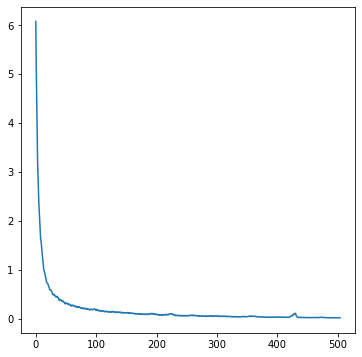

In [43]:
# Cost plot
plt.figure(figsize=(6,6))
plt.plot(Ctrain)
plt.show()